In [1]:
!date

Tue Jan 19 18:06:21 PST 2021


# Memory and time

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import matplotlib
import json

matplotlib.rcParams.update({'font.size': 20})

%config InlineBackend.figure_format = 'retina'

In [62]:
run_log = sorted(glob.glob('../../data/kallisto_out/*/run_info.json'))

In [63]:
nreads = []
for r in run_log:
    with open(r, 'r') as f:
        nreads.append(json.load(f)["n_processed"])

In [18]:
def get_time(line):
    # returns milliseconds
    ftr = [60*60*1000, 60*1000, 1000, 1]
    t = ":".join(line.split(":")[4:]).strip()
    t = t.replace(".", ":")
    if len(t.split(":")) ==3:
        t = "00:" + t
    ms = sum([a*b for a,b in zip(ftr, map(int,t.split(':')))])
    return ms
        
def get_mem(line):
    # returns bytes
    mem = int(line.split(':')[-1].strip())*1000
    return mem

def get_memtime(f):
    with open(f, 'r') as file:
        for idx, line in enumerate(file):
            if idx == 4:
                time = get_time(line)
            if idx == 9:
                mem = get_mem(line)
    return (mem, time)

In [19]:
steps = ['pseudoalignment', 'correct', 'sort', 'count']

In [65]:
# kb files
d = {}
for step in steps:
    d[step] = {"time": [], "mem": []}
    files = sorted(glob.glob(f'../../data/kallisto_out/*/{step}.log'))

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem

In [66]:
names = [f.split("/")[4] for f in files]

kb = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})
kb.index = names
kb['nreads'] = nreads

In [67]:
# alevin files
d = {}
for step in steps:
    d[step] = {"time": [], "mem": []}
    files = sorted(glob.glob(f'../../data/alevin_out/*/{step}.log'))

    mem = []
    time = []
    for f in files:
        m, t = get_memtime(f)
        mem.append(m)
        time.append(t)
    d[step]['time'] = time
    d[step]['mem'] = mem

In [69]:
names = [f.split("/")[4] for f in files]

al = pd.DataFrame.from_dict({(i,j): d[i][j] 
                           for i in d.keys() 
                           for j in d[i].keys()})
al.index = names
al['nreads'] = nreads

In [70]:
kb

pseudoalignment             correct             \
                                     time         mem    time        mem   
arabidopsis-SRR8257100_v2          902093  1840536000   29049   44268000   
fly-SRR8513910_v2                  675094  1786536000   16081   44260000   
human-SRR8327928_v2                695054  3861884000   20073   44264000   
human-SRR8524760_v2                348070  3858280000    8054   44264000   
human-pbmc10k_v3                  1936062  3846500000   93021  316756000   
human-pbmc1k_v3                    218063  3789452000   11053  316756000   
human_mouse-hgmm10k_v3            2172029  7552620000  127035  316776000   
human_mouse-hgmm1k_v2              251004  7483212000    8044   44264000   
human_mouse-hgmm1k_v3              213023  7480604000   12094  316780000   
mouse-EMTAB7320_v2                1730009  3634764000   41063   44260000   
mouse-SRR6998058_v2                171046  3609084000    3041   44260000   
mouse-SRR8206317_v2                243033  3676224000   13098   44260000   
mouse-SRR8599150_v2                 50082  3595784000    1013   44068000   
mouse-SRR8639063_v2               1532089  3803028000   39049   44264000   
mouse-heart1k_v2                   278077  3598520000    8052   44256000   
mouse-heart1k_v3                   259056  3598024000   15017  316756000   
mouse-neuron10k_v3                1049000  3603912000   50068  316772000   
rat-SRR7299563_v2                  398048  1884868000    7095   44260000   
worm-SRR8611943_v2                  77038  1047956000    3076   44264000   
zebrafish-SRR6956073_v2            461070  3519448000   15084   44264000   

                             sort              count                nreads  
                             time         mem   time        mem             
arabidopsis-SRR8257100_v2   41038  8390096000  38075   61308000  189337914  
fly-SRR8513910_v2           25032  8390096000   3054   41864000  146617182  
human-SRR8327928_v2         26092  8390096000  20067  264404000  190094560  
human-SRR8524760_v2         15043  8390092000   5032  238572000   97106426  
human-pbmc10k_v3            90047  8390096000  35015  324628000  638901019  
human-pbmc1k_v3             11003  8390092000   5064  247440000   66601887  
human_mouse-hgmm10k_v3     148076  8390100000  85020  570952000  721180737  
human_mouse-hgmm1k_v2       14067  8390096000  10058  444856000   75225120  
human_mouse-hgmm1k_v3       12043  8390072000  11047  449428000   63105786  
mouse-EMTAB7320_v2          57097  8390096000  19011  151840000  335147976  
mouse-SRR6998058_v2          7071  8390080000   2092  127588000   37227612  
mouse-SRR8206317_v2         22017  8390096000  11035  141504000   85992089  
mouse-SRR8599150_v2          3029  8390036000   1097  122020000    8860361  
mouse-SRR8639063_v2         92093  8390104000  37074  151636000  416437344  
mouse-heart1k_v2            14054  8390096000   3030  136428000   88872840  
mouse-heart1k_v3            13072  8390096000   5072  147180000   84512390  
mouse-neuron10k_v3          50066  8390092000  32067  172012000  357111595  
rat-SRR7299563_v2           14060  8390092000   5049   37436000  112176350  
worm-SRR8611943_v2           5076  8390036000   5009   30392000   21574502  
zebrafish-SRR6956073_v2     22084  8390092000  10055   72796000  161274652

# Plot

In [84]:
kallisto_color = "#e41a1c"
alevin_color = '#377eb8'
alpha = 0.2

In [104]:
def plot_time(step, kb, al, ax, label_axis=False):
    measurement = "time"

    title = f"{step}"

    for nr in kb['nreads']:
        ax.axvline(x=nr,linewidth=1, color='lightgrey', linestyle='--', zorder=1)

    x = kb['nreads']
    y = kb[f'{step}'][f'{measurement}']/1000/60

    ax.scatter(x,y, color=kallisto_color, label="kallisto")

    x = al['nreads']
    y = al[f'{step}'][f'{measurement}']/1000/60

    ax.scatter(x,y, color=alevin_color, zorder=-1, label= "alevin")

    if label_axis:
        ## add labels on top
        ax2 = ax.twiny()
        ax2.set(**{
            "xticks": np.linspace(kb['nreads'].min(), kb['nreads'].max(), kb.shape[0]),
            "xticklabels": kb.sort_values('nreads').index.values
        })

        for label in ax2.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment("left")

        ax2.tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

    ax.set(**{
        'xscale': "log",
        'yscale': 'log',
        'xlabel': "Number of reads",
        "ylabel": f"Processing {measurement} [min]"

    })

    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = alpha)
    ax.set_title(title, fontweight='bold', loc = 'left' )

    ax.legend()
    return ax

In [118]:
def plot_mem(step, kb, al, ax, label_axis=False):
    measurement = "mem"

    title = f"{step}"

    for nr in kb['nreads']:
        ax.axvline(x=nr,linewidth=1, color='lightgrey', linestyle='--', zorder=1)

    x = kb['nreads']
    y = kb[f'{step}'][f'{measurement}']/10**9

    ax.scatter(x,y, color=kallisto_color, label="kallisto")

    x = al['nreads']
    y = al[f'{step}'][f'{measurement}']/10**9

    ax.scatter(x,y, color=alevin_color, zorder=-1, label= "alevin")


    if label_axis:
        ## add labels on top
        ax2 = ax.twiny()
        ax2.set(**{
            "xticks": np.linspace(kb['nreads'].min(), kb['nreads'].max(), kb.shape[0]),
            "xticklabels": kb.sort_values('nreads').index.values
        })

        for label in ax2.get_xticklabels():
            label.set_rotation(45)
            label.set_horizontalalignment("left")

        ax2.tick_params(
            axis='x',          # changes apply to the x-axis
            which='minor',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off

    ax.set(**{
        'xscale': "log",
        'xlabel': "Number of reads",
        "ylabel": f"Processing {measurement} [Gb]"

    })

    ax.grid(color='dimgrey', linestyle='-', linewidth=0.5, which="both", alpha = alpha)
    ax.set_title(title, fontweight='bold', loc = 'left' )

    ax.legend()
    return ax

In [124]:
al['max', 'mem']  =al[[('pseudoalignment', 'mem'), ('correct', 'mem'), ('sort', 'mem'), ('count', 'mem')]].max(axis=1)

In [126]:
kb['sum', 'time'] = kb['pseudoalignment']['time'] + kb['correct']['time'] + kb['sort']['time'] + kb['count']['time']
kb['max', 'mem']  = kb[[('pseudoalignment', 'mem'), ('correct', 'mem'), ('sort', 'mem'), ('count', 'mem')]].max(axis=1)

al['sum', 'time'] = al['pseudoalignment']['time'] + al['correct']['time'] + al['sort']['time'] + al['count']['time']
al['max', 'mem']  = al[[('pseudoalignment', 'mem'), ('correct', 'mem'), ('sort', 'mem'), ('count', 'mem')]].max(axis=1)

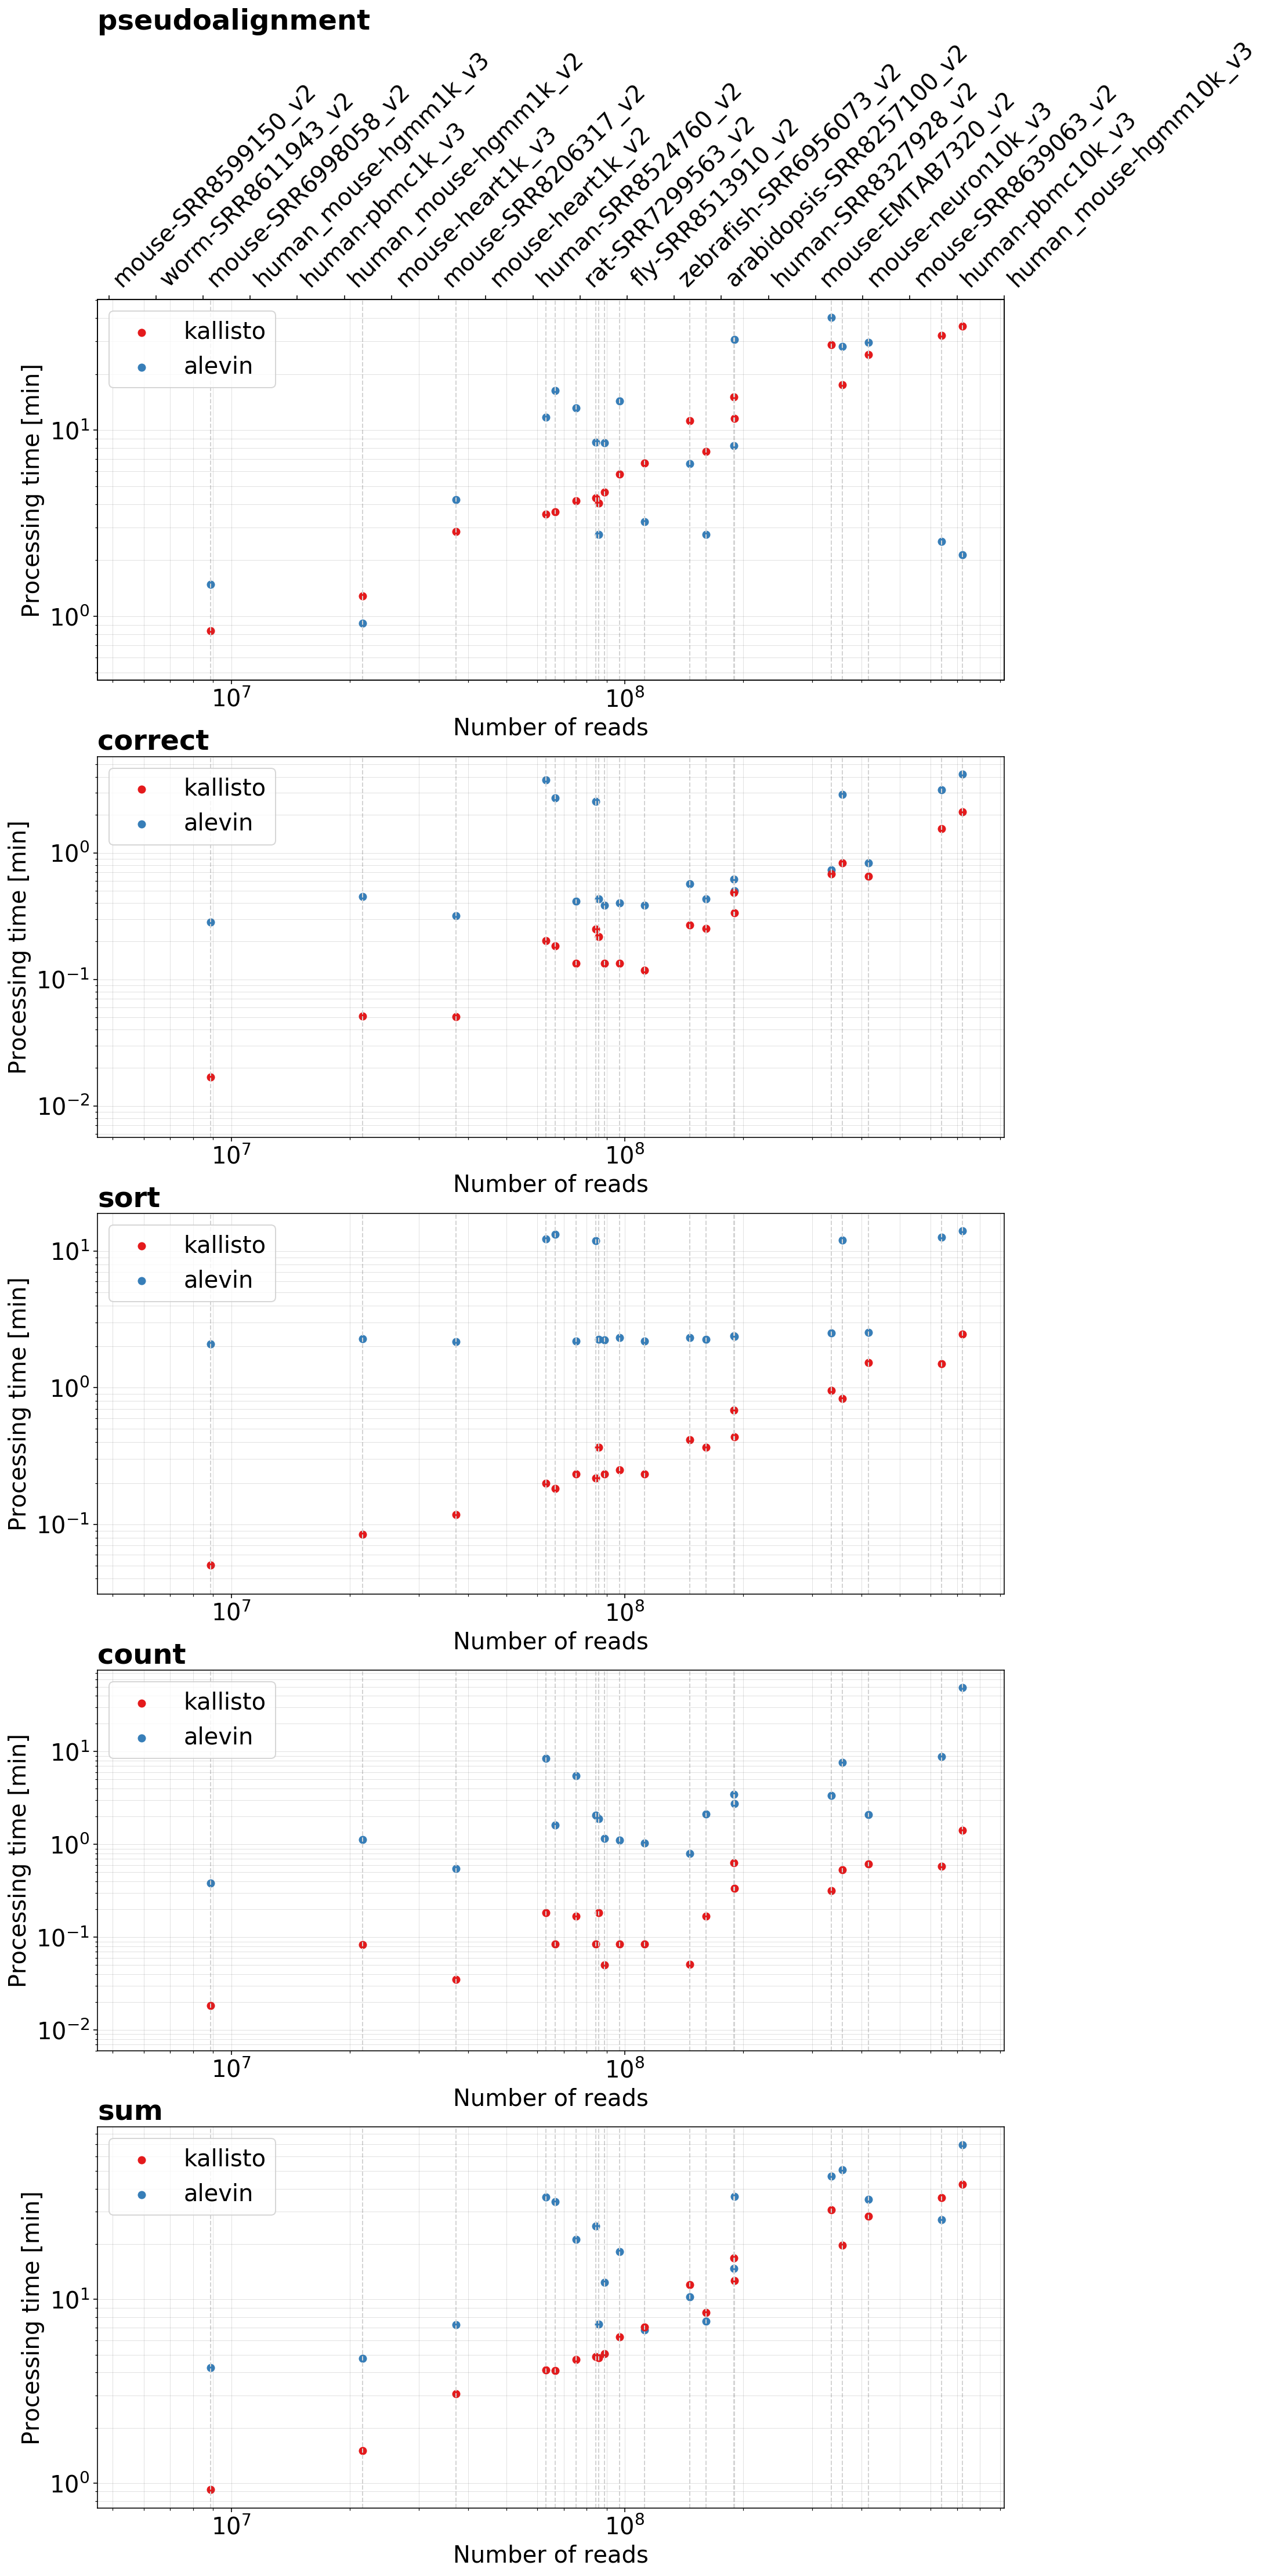

In [116]:
n=5
fig, ax = plt.subplots(figsize=(14, n*7), nrows=n)

plot_time("pseudoalignment", kb, al, ax[0], label_axis=True)
plot_time("correct", kb, al, ax[1])
plot_time("sort", kb, al, ax[2])
plot_time("count", kb, al, ax[3])
plot_time('sum', kb, al, ax[4])

fig.show()

# Memory

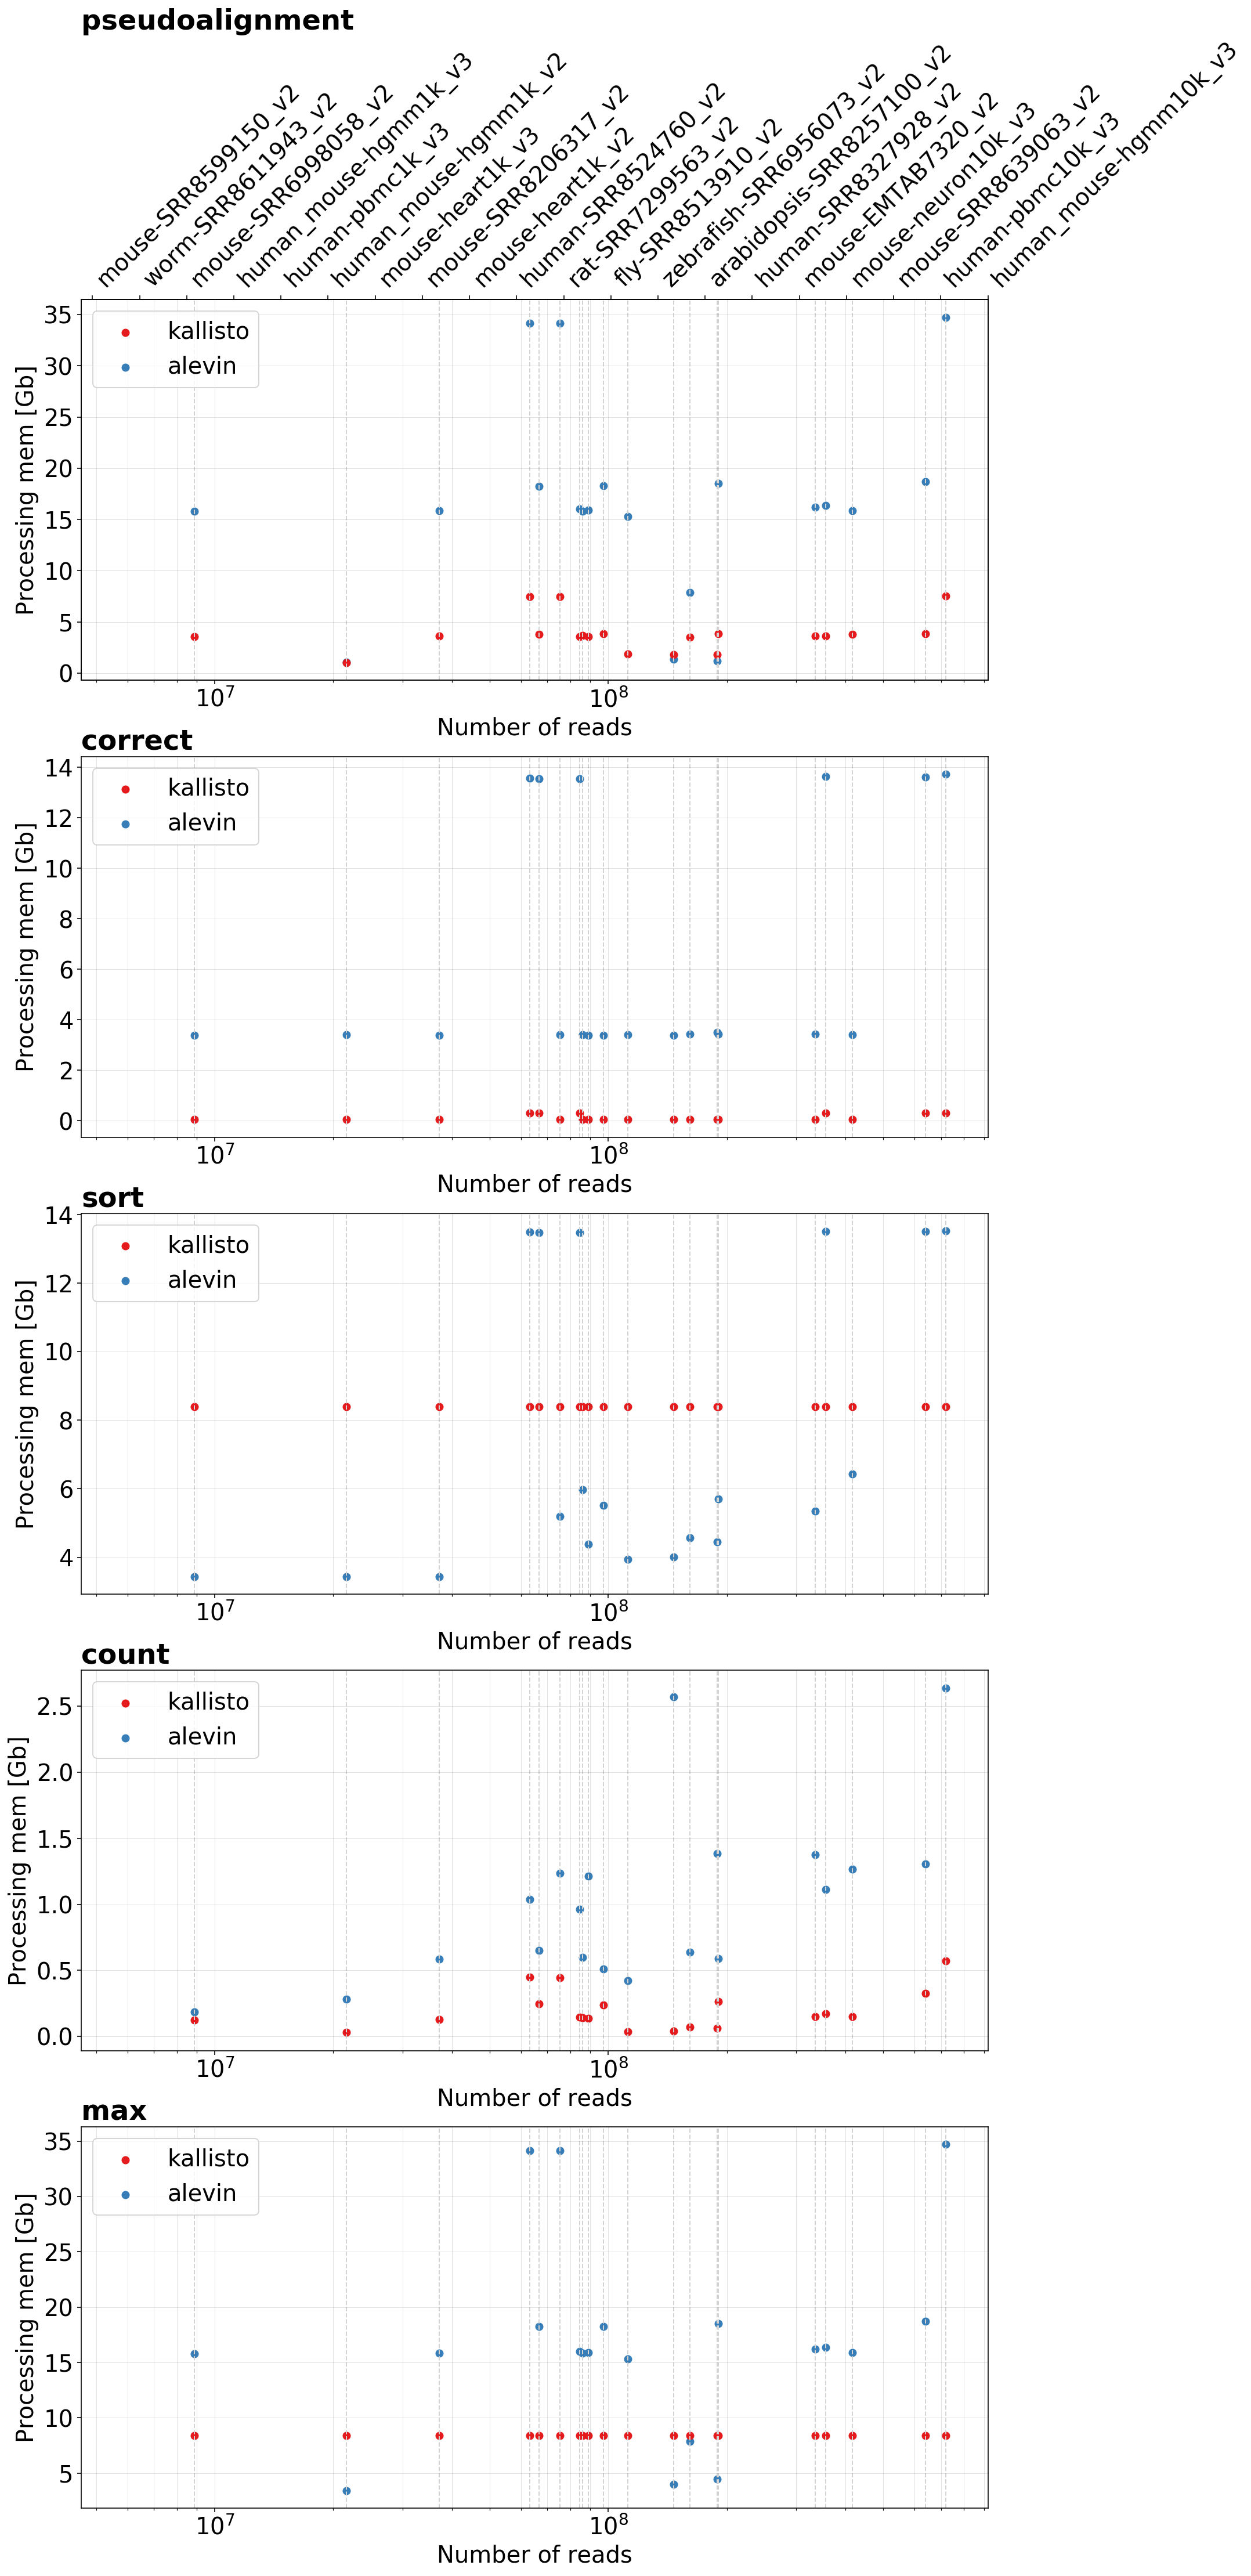

In [127]:
n=5
fig, ax = plt.subplots(figsize=(14, n*7), nrows=n)

plot_mem("pseudoalignment", kb, al, ax[0], label_axis=True)
plot_mem("correct", kb, al, ax[1])
plot_mem("sort", kb, al, ax[2])
plot_mem("count", kb, al, ax[3])
plot_mem("max", kb, al, ax[4])

fig.show()